In [1]:
#%pip install tensorflow
import tensorflow as tf
import pandas as pd
## Load in data

tickets = pd.read_csv("master_dataset.csv")

In [8]:
import numpy as np

def bagOfWordsEncoder(vocab, input):
    ## Make an array size of the vocab
    encoderMatrix = np.zeros(len(vocab))

    ## Iterate the input strings and encode their position in the array
    for word in input:
        index = vocab[vocab['word']==word].index.values
        encoderMatrix[index] += 1
    
    if encoderMatrix.std() != 0:
        encoderMatrix = (encoderMatrix - encoderMatrix.mean()) / encoderMatrix.std()
    return encoderMatrix

## Method for getting input
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download("punkt")
nltk.download('wordnet')
nltk.download("stopwords")

def parse_text(text):

    ## Tokenize string into words (and punctuation)
    word_array = word_tokenize(text)
    word_array = [word.lower() for word in word_array if word.isalpha()]

    ## Filter out stop words
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in word_array if word.casefold() not in stop_words]

    ## Turn words into lemmatized words
    lemmatizer = WordNetLemmatizer()
    lemitized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    ## Apply Stemming (Find the roots of similar words)
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in lemitized_words]

    return stemmed_words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:

vocab = pd.read_csv("reduced_vocabulary.csv")
#vocab = vocab['word'].tolist()
encodings = []
efforts = tickets['effort(s)'].to_numpy()

## Count tickets

descs = tickets['desc'].to_numpy()
for desc in descs:
    parsed = parse_text(desc)
    encoding = bagOfWordsEncoder(vocab, parsed)
    encodings.append(encoding)


In [73]:

## Gather training data
from sklearn.model_selection import train_test_split
labels = pd.read_csv("labelled_dataset.csv")

labels = labels['Grade'].tolist()
labels = [(label - 1)/2 for label in labels]

data = {'encoding': encodings, 'effort': labels}
df = pd.DataFrame(data)

## simplify data ~ 10000
df_low_effort = df[df.effort == 0.0].sample(19000)
df_med_effort = df[df.effort == 0.5].sample(19000)
df_hig_effort = df[df.effort == 1.0].sample(19000)

print(len(df_low_effort))
print(len(df_med_effort))
print(len(df_hig_effort))

result = pd.concat([df_low_effort, df_med_effort, df_hig_effort], axis=0)

train, test = train_test_split(result, test_size=0.2, shuffle=True)

x_train = tf.convert_to_tensor(train['encoding'].to_list())
y_train = tf.convert_to_tensor(train['effort'])

x_test = tf.convert_to_tensor(test['encoding'].to_list())
y_test = tf.convert_to_tensor(test['effort'])

19000
19000
19000


In [118]:
## SETUP NEURAL NETWORK

from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(2742,1)))
model.add(keras.layers.Dense(128))
model.add(keras.layers.Activation("relu"))

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(256))
model.add(keras.layers.Activation("relu"))

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation("relu"))

model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation("sigmoid"))

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.005), loss="mean_squared_error", metrics=["accuracy"])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, shuffle=True)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Tested Acc: ", test_acc)

Epoch 1/20
1425/1425 [==============================] - 6s 4ms/step - loss: 0.1702 - accuracy: 0.3518 - val_loss: 0.1613 - val_accuracy: 0.3776
Epoch 2/20
1425/1425 [==============================] - 6s 4ms/step - loss: 0.1633 - accuracy: 0.3843 - val_loss: 0.1573 - val_accuracy: 0.4001
Epoch 3/20
1425/1425 [==============================] - 6s 4ms/step - loss: 0.1594 - accuracy: 0.4036 - val_loss: 0.1544 - val_accuracy: 0.4112
Epoch 4/20
1425/1425 [==============================] - 6s 4ms/step - loss: 0.1559 - accuracy: 0.4181 - val_loss: 0.1524 - val_accuracy: 0.4172
Epoch 5/20
1425/1425 [==============================] - 6s 4ms/step - loss: 0.1537 - accuracy: 0.4250 - val_loss: 0.1511 - val_accuracy: 0.4233
Epoch 6/20
1425/1425 [==============================] - 6s 4ms/step - loss: 0.1515 - accuracy: 0.4320 - val_loss: 0.1498 - val_accuracy: 0.4286
Epoch 7/20
1425/1425 [==============================] - 6s 4ms/step - loss: 0.1498 - accuracy: 0.4396 - val_loss: 0.1491 - val_accuracy:

1425/1425 [==============================] - 3s 2ms/step
[[0.50197065]
 [0.6390387 ]
 [0.80428326]
 ...
 [0.561839  ]
 [0.46216592]
 [0.8015974 ]]
[0.5 0.5 1.  ... 1.  0.  1. ]


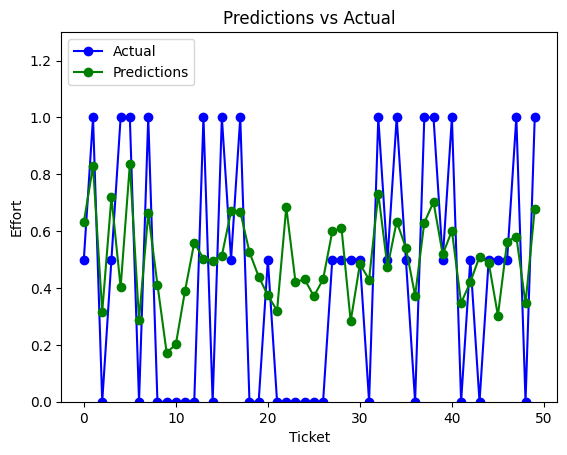

In [163]:
## plot the predictions of test data
predictions = model.predict(x_train)
print(predictions)
print(y_train.numpy())

import matplotlib.pyplot as plt

plt.plot(y_train[50:100], 'bo-', label="Actual")
plt.plot(predictions[50:100], 'go-', label="Predictions")

plt.title("Predictions vs Actual")
plt.xlabel("Ticket")
plt.ylabel("Effort")

plt.legend(loc="upper left")
plt.ylim(0, 1.3)

plt.show()

tf.Tensor(
[[-0.07942841 -0.07942841 -0.07942841 ... -0.07942841 -0.07942841
  -0.07942841]], shape=(1, 2742), dtype=float64)
1/1 [==============================] - 0s 24ms/step
[[0.50197065]]
tf.Tensor(
[ 0.00161789  0.00081212  0.00012006 ... -0.00165286 -0.00107149
 -0.00299989], shape=(2742,), dtype=float64)


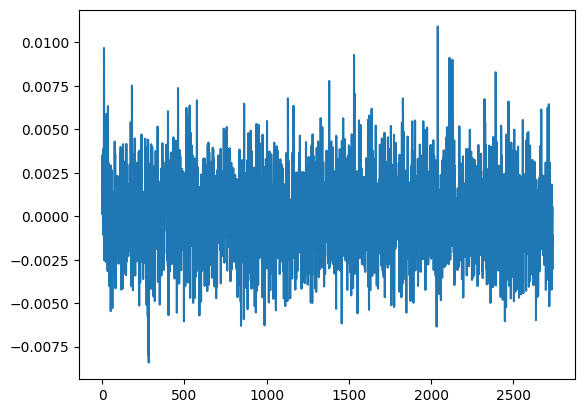

In [179]:
sample = tf.reshape(x_train[0], (1, 2742))
print(sample)
result = model.predict(sample)
print(result)

with tf.GradientTape() as tape:
    tape.watch(sample)
    result = model(sample)
grads = tape.gradient(result, sample)

print(grads[0])
plt.plot(grads[0].numpy())
plt.show()

In [182]:
temp = abs(grads[0].numpy())
counter = 0
indexs = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
while counter < 10:
    indexs[counter] = temp.argmax()
    temp[indexs[counter]] = 0
    counter += 1


print(indexs)

[2041, 12, 1532, 2112, 2130, 284, 2393, 282, 1381, 182]
